# Import

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

# Load Image

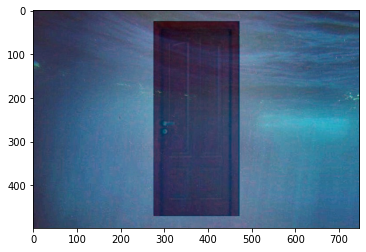

In [ ]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img
path = r'/content/blue.jpg'
img=load_image(path)
plt.imshow(img)

# Display Color channels

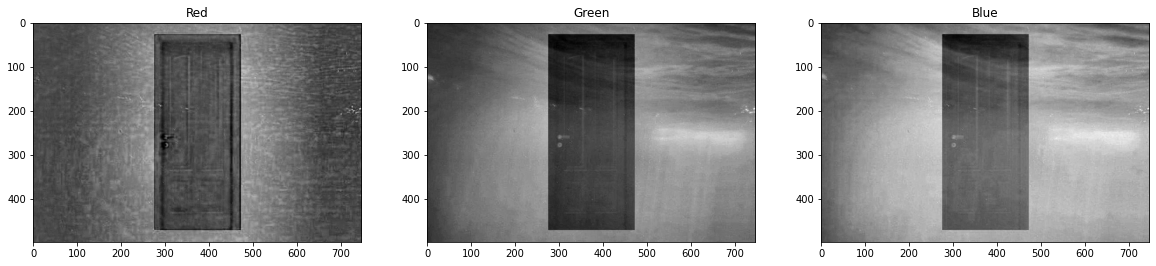

In [ ]:
def disp_channel(image,space):
    if(space=='rgb'):
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Red')
        ax1.imshow(r, cmap='gray')
        ax2.set_title('Green')
        ax2.imshow(g, cmap='gray')
        ax3.set_title('Blue')
        ax3.imshow(b, cmap='gray')
    elif(space=='hsv'):
        # Convert from RGB to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        # HSV channels
        h = hsv[:,:,0]
        s = hsv[:,:,1]
        v = hsv[:,:,2]
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Hue')  #Hue threshold produces better distinction between pink and other colors
        ax1.imshow(h, cmap='gray')
        ax2.set_title('Saturation')
        ax2.imshow(s, cmap='gray')
        ax3.set_title('Value')
        ax3.imshow(v, cmap='gray')
disp_channel(img,'rgb')

# Kmap

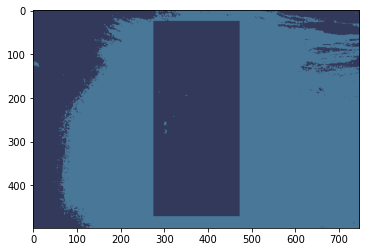

In [ ]:
def segement_kmap(image,k):
    pixel_vals = image.reshape((-1,3)) 
    pixel_vals = np.float32(pixel_vals)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    #print(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((image.shape))
    labels_reshape = labels.reshape(image.shape[0], image.shape[1])
    return segmented_image
plt.imshow(segement_kmap(img,2))

# Canny Edge 

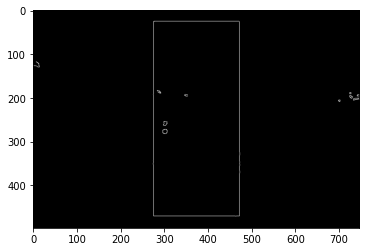

In [ ]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 30, 200)
    plt.figure()
    return edged
def auto_canny(image, sigma=0.33):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  v = np.median(blurred)	# compute the median of the single channel pixel intensities
  lower = int(max(0, (1.0 - sigma) * v))	# apply automatic Canny edge detection using the computed median
  upper = int(min(255, (1.0 + sigma) * v))
  edged = cv2.Canny(blurred, lower, upper)
  plt.figure()
  # return the edged image
  return edged  
plt.imshow(auto_canny(img), cmap='gray')

# Thresholding

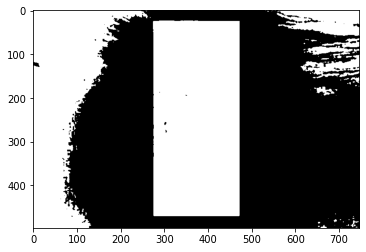

In [ ]:
def col_thresh(image,ch,lower=[0],upper=[120]):
  if(ch=='hsv'):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    th = cv2.inrange(hsv,lower,upper)
    plt.figure()
    return th
  elif(ch=='graythresh'):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    ret3,th = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8) 
    img_erosion = cv2.erode(img, kernel, iterations=1) 
    img_dilation = cv2.dilate(img, kernel, iterations=1) 
    return th
plt.imshow(col_thresh(image=img,ch='graythresh'),'gray')

#Contour Detection Detect


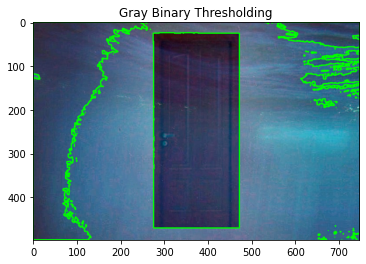

<Figure size 432x288 with 0 Axes>

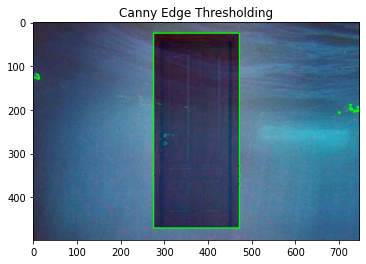

In [ ]:
cnts,h = cv2.findContours(col_thresh(img,'graythresh'),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.figure()
plt.title('Gray Binary Thresholding')
plt.imshow(cv2.drawContours(img.copy(),cnts, -1, (0, 255, 0), 2))
cnts1,h = cv2.findContours(auto_canny(img.copy()),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.figure()
plt.title('Canny Edge Thresholding')
plt.imshow(cv2.drawContours(img.copy(),cnts1, -1, (0, 255, 0), 2))

In [ ]:
color=(input('Please enter color of the door '))
h=float(input('Please enter height of the door '))
w=float(input('Please enter width of the door '))

Please enter color of the door red
Please enter height of the door 400
Please enter width of the door 200


# Centre Detection on Canny Edge Thresholded

In [ ]:
def detect(c):
	# initialize the shape name and approximate the contour
	shape = "unidentified"
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.04 * peri, True)
  # if the shape is a triangle, it will have 3 vertices
	if len(approx) == 3:
		shape = "triangle"
	# if the shape has 4 vertices, it is either a square or
	# a rectangle
	elif len(approx) == 4:
		# compute the bounding box of the contour and use the
		# bounding box to compute the aspect ratio
		(x, y, w, h) = cv2.boundingRect(approx)
		ar = w / float(h)
		# a square will have an aspect ratio that is approximately
		# equal to one, otherwise, the shape is a rectangle
		shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
	# if the shape is a pentagon, it will have 5 vertices
	elif len(approx) == 5:
		shape = "pentagon"
	# otherwise, we assume the shape is a circle
	else:
		shape = "circle"
	# return the name of the shape
	return shape


In [ ]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import cv2
class ColorLabeler:
	def __init__(self):
		# initialize the colors dictionary, containing the color
		# name as the key and the RGB tuple as the value
		colors = OrderedDict({
			"red": (255, 0, 0),
			"green": (0, 255, 0),
			"blue": (0, 0, 255)})
		# allocate memory for the L*a*b* image, then initialize
		# the color names list
		self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
		self.colorNames = []
		# loop over the colors dictionary
		for (i, (name, rgb)) in enumerate(colors.items()):
			# update the L*a*b* array and the color names list
			self.lab[i] = rgb
			self.colorNames.append(name)
		# convert the L*a*b* array from the RGB color space
		# to L*a*b*
		self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)
  
	def label(self, image, c):
		# construct a mask for the contour, then compute the
		# average L*a*b* value for the masked region
		mask = np.zeros(image.shape[:2], dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)
		mask = cv2.erode(mask, None, iterations=2)
		mean = cv2.mean(image, mask=mask)[:3]
		# initialize the minimum distance found thus far
		minDist = (np.inf, None)
		# loop over the known L*a*b* color values
		for (i, row) in enumerate(self.lab):
			# compute the distance between the current L*a*b*
			# color value and the mean of the image
			d = dist.euclidean(row[0], mean)
			# if the distance is smaller than the current distance,
			# then update the bookkeeping variable
			if d < minDist[0]:
				minDist = (d, i)
		# return the name of the color with the smallest distance
		return self.colorNames[minDist[1]]

In [ ]:
def returnarea(cnts):
  areas=[]
  for c in cnts:
    areas.append(cv2.contourArea(c))
  maxi=max(areas)
  return maxi
def constraint(c,img):
  shape = detect(c)
  blurred = cv2.GaussianBlur(img, (5, 5), 0)
  gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
  lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
  cl = ColorLabeler()
  color = cl.label(lab, c)
  if(color=='red' and (shape=='rectangle' or shape=='square')):
    return True,color,shape
  else:
    return False,color,shape  


12903.01769326301
Number of Countours detected:  3
2.0
2.5
14132.5


<Figure size 432x288 with 0 Axes>

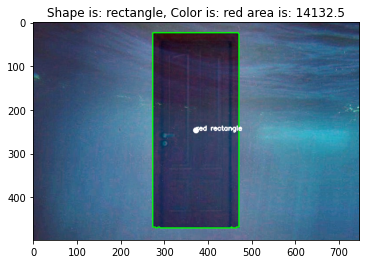

In [ ]:
def findshape(image1,w,h):
	image=image1.copy()
	resized = imutils.resize(image, width=300)
	newimage=np.copy(resized)
	#plt.show()
	ratio = image.shape[0] / float(resized.shape[0])
	wc=w/ratio
	hc=h/ratio
	expected_area=wc*hc
	print(expected_area)
	cnts,h = cv2.findContours(auto_canny(resized),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
	print('Number of Countours detected: ',len(cnts))
	selected_contor=[]
	for c in cnts:
		M = cv2.moments(c)	# compute the center of the contour, then detect the name of the
		cX = int((M["m10"] / (M["m00"]+0.00001)) * ratio)	# shape using only the contour
		cY = int((M["m01"] / (M["m00"]+0.00001)) * ratio)
		condn,color,shape = constraint(c,newimage)
		text = "{} {}".format(color, shape)
		area=cv2.contourArea(c)
		print(area)
		if((shape=='rectangle' or shape=='square') and area>=expected_area/10):
			# multiply the contour (x, y)-coordinates by the resize ratio,
			# then draw the contours and the nam;e of the shape on the image
			c = c.astype("float")
			c *= ratio
			c = c.astype("int")
			image=image1.copy()
			cv2.drawContours(image, [c], 0, (0, 255, 0), 2)
			cv2.putText(image, text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,	0.5, (255, 255, 255), 2)
			cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
			ares=' '
			plt.figure()
			if (abs(area-expected_area)/expected_area)<=0.6:
				ares=' area is: ' + str(area)
			plt.title('Shape is: '+shape+', Color is: ' + color + ares)
			plt.imshow(image)	# show the output image
			selected_contor.append(c)
	return selected_contor
selected_contor= findshape(img.copy(),w,h)

## Centre detection on Gray Binary **Thresholded**

12903.01769326301
Number of Countours detected:  13
2.0
0.0
0.5
35.5
6.5
416.5
1.5
0.0
0.0
255.5
13894.5
1284.0
9517.0


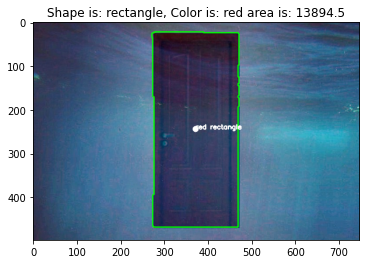

In [ ]:
def findshape(image1,w,h):
	image=image1.copy()
	resized = imutils.resize(image, width=300)
	newimage=np.copy(resized)
	#plt.show()
	ratio = image.shape[0] / float(resized.shape[0])
	wc=w/ratio
	hc=h/ratio
	expected_area=wc*hc
	print(expected_area)
	cnts,h = cv2.findContours(col_thresh(resized,'graythresh'),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
	print('Number of Countours detected: ',len(cnts))
	selected_contor=[]
	for c in cnts:
		M = cv2.moments(c)	# compute the center of the contour, then detect the name of the
		cX = int((M["m10"] / (M["m00"]+0.00001)) * ratio)	# shape using only the contour
		cY = int((M["m01"] / (M["m00"]+0.00001)) * ratio)
		condn,color,shape = constraint(c,newimage)
		text = "{} {}".format(color, shape)
		area=cv2.contourArea(c)
		print(area)
		if((shape=='rectangle' or shape=='square') and area>=expected_area/10):
			# multiply the contour (x, y)-coordinates by the resize ratio,
			# then draw the contours and the nam;e of the shape on the image
			c = c.astype("float")
			c *= ratio
			c = c.astype("int")
			image=image1.copy()
			cv2.drawContours(image, [c], 0, (0, 255, 0), 2)
			cv2.putText(image, text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,	0.5, (255, 255, 255), 2)
			cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
			ares=' '
			plt.figure()
			if (abs(area-expected_area)/expected_area)<=0.6:
				ares=' area is: ' + str(area)
			plt.title('Shape is: '+shape+', Color is: ' + color + ares)
			plt.imshow(image)	# show the output image
			selected_contor.append(c)
	return selected_contor
selected_contor= findshape(img.copy(),w,h)